In [1]:
from datetime import datetime, timedelta
import math
import os.path
import pickle
import shutil
import sys
import time

import iisignature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import arff
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as shuff

sys.path.insert(0, os.path.join('..', '..', 'empirical-outliers'))
import variance
sys.path.insert(0, os.path.join('..', 'common'))
import util

In [2]:
np.random.seed(0)

In [3]:
t0 = time.time()

Download and extract dataset, if it does not already exist:

In [4]:
DATASET_PATH = 'Univariate_arff'
ZIP_URL = 'http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_arff.zip'
ZIP_PATH = 'Univariate2018_arff.zip'

if not os.path.exists(DATASET_PATH) and not os.path.exists(ZIP_PATH):
    try:
        util.download(ZIP_URL, ZIP_PATH)

        # Extract dataset
        !unzip {ZIP_PATH}
    except:
        if os.path.exists(DATASET_PATH):
            shutil.rmtree(DATASET_PATH)
        raise
    finally:
        if os.path.exists(ZIP_PATH):
            os.remove(ZIP_PATH)

In [5]:
comparisons = pd.read_csv('results_beggel_et_al_2019_tables_2_and_4.csv')

In [6]:
def get_corpus_and_outlier_paths(df,desired_class):
    corpus_paths=[]
    outlier_paths = []
    
    for i in range(df.shape[0]):
        if df.iloc[i]['target'] == desired_class:
            corpus_paths.append(np.column_stack([[i for i in range(df.shape[1] - 1)], df.iloc[i][:-1]]))
        else:
            outlier_paths.append(np.column_stack([[i for i in range(df.shape[1] - 1)], df.iloc[i][:-1]]))  
    
    return corpus_paths, outlier_paths

In [7]:
def compute_variances(corpus_paths, outlier_paths, test_size, outliers_to_train=0, sig_order=4, random_state=0):
    corpus_train, corpus_test = train_test_split(corpus_paths, test_size=test_size, random_state=random_state)
    
    if outliers_to_train==0:
        outliers_shuffled = shuff(outlier_paths, random_state=0)
    else:
        outliers_shuffled, outlier_paths_to_train = train_test_split(outlier_paths, test_size=outliers_to_train,
                                                                     random_state=random_state)
        corpus_train=corpus_train + outlier_paths_to_train
    
    variance_corpus = variance.variance(corpus_test, corpus_train, sig_order)
    variance_outliers = variance.variance(outliers_shuffled, corpus_train, sig_order)

    corpus_variances = [y for y,_ in sorted(zip(variance_corpus, corpus_test), reverse=True, key=lambda x: x[0])]
    outlier_variances = [y for y,_ in sorted(zip(variance_outliers,outliers_shuffled),
                                             reverse=True, key=lambda x: x[0])]
    
    return corpus_variances, outlier_variances

In [8]:
def evaluate(anomaly_level_column='Atra', signature_order=5):
    tnfn = {}

    for i in range(len(comparisons)):
        d=comparisons.iloc[i].Dataset
        tnfn[d] = []
        
        datatrain = arff.loadarff(os.path.join(DATASET_PATH, d, d + "_TRAIN.arff"))
        datatest = arff.loadarff(os.path.join(DATASET_PATH, d, d + "_TEST.arff"))

        alldata = pd.concat([pd.DataFrame(datatrain[0]),pd.DataFrame(datatest[0])],ignore_index=True)
        alldata['target'] = pd.to_numeric(alldata['target'])
        corpus_paths, outlier_paths = get_corpus_and_outlier_paths(alldata,comparisons.iloc[i].normal)
        
        for j in range(10):
            corpus_variances, outlier_variances = \
                compute_variances(corpus_paths, outlier_paths, comparisons.iloc[i].Ntes, sig_order=5,
                                  outliers_to_train = comparisons.iloc[i][anomaly_level_column], random_state=j)
            
            tn = np.concatenate([[0], np.cumsum(np.array([y for _,y in sorted(zip(corpus_variances+outlier_variances,[0]*len(corpus_variances)+[1]*len(outlier_variances)))])==0)])
            fn = np.concatenate([[0], np.cumsum(np.array([y for _,y in sorted(zip(corpus_variances+outlier_variances,[0]*len(corpus_variances)+[1]*len(outlier_variances)))])==1)])
            
            false_pos = np.flip(max(tn) - tn)
            true_pos = np.flip(max(fn) - fn)

            true_neg = max(false_pos) - false_pos
            false_neg = max(true_pos) - true_pos

            sens = true_pos / (true_pos + false_neg)
            spec = true_neg / (true_neg + false_pos)

            tnfn[d].append((tn, fn))

    return tnfn

Compute for anomaly rates 0.1% and 5%:

In [9]:
%%time
tnfn1 = evaluate(anomaly_level_column='Atra')
tnfn5 = evaluate(anomaly_level_column='A5tra')

Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 143.34it/s]

Preparing...


Computing signatures:   0%|          | 0/16 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 761/761 [00:00<00:00, 8652.83it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/16 [00:00<?, ?it/s]


Done.
Preparing...


Computing variances: 100%|██████████| 761/761 [00:00<00:00, 8565.57it/s]

Done.
Preparing...



Computing signatures:   0%|          | 0/16 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/16 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 761/761 [00:00<00:00, 9215.30it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/16 [00:00<?, ?it/s]


Done.
Preparing...


Computing signatures:   0%|          | 0/16 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 761/761 [00:00<00:00, 11946.23it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4430.84it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3346.38it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3861.88it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3911.19it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4765.00it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4244.26it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/146 [00:00<?, ?it/s]

Done.


Computing signatures: 100%|██████████| 52/52 [00:00<00:00, 260.09it/s]

Preparing...



Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4282.25it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3534.22it/s]

Done.



Computing signatures:  48%|████▊     | 25/52 [00:00<00:00, 240.95it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 25.96it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 3002.37it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 136.39it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 3175.10it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 143.84it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 1675.04it/s]


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 3215.26it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 156.48it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 2195.40it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 144.86it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 3109.19it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 144.58it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 2024.77it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 152.91it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 3252.66it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 150.92it/s]

Preparing...


Computing variances: 100%|██████████| 2/2 [00:00<00:00, 3072.75it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 148.10it/s]

Preparing...


Computing variances:   0%|          | 0/48 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/16 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 3510.61it/s]


Done.


Computing signatures:  24%|██▍       | 60/248 [00:00<00:00, 595.71it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3836.91it/s]

Done.



Computing signatures:  50%|█████     | 124/248 [00:00<00:00, 605.27it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 4163.01it/s]

Done.



Computing signatures:  47%|████▋     | 116/248 [00:00<00:00, 598.62it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3935.21it/s]

Done.



Computing signatures:  51%|█████     | 126/248 [00:00<00:00, 622.23it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 4052.59it/s]

Done.



Computing signatures:  49%|████▉     | 122/248 [00:00<00:00, 606.75it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 4279.41it/s]

Done.



Computing signatures:  46%|████▋     | 115/248 [00:00<00:00, 543.24it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3948.30it/s]

Done.



Computing signatures:  50%|█████     | 124/248 [00:00<00:00, 627.53it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 4008.31it/s]

Done.



Computing signatures:  51%|█████     | 127/248 [00:00<00:00, 635.52it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 4187.48it/s]

Done.



Computing signatures:  44%|████▍     | 109/248 [00:00<00:00, 555.76it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 4023.38it/s]

Done.



Computing signatures:  51%|█████     | 126/248 [00:00<00:00, 622.02it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3907.19it/s]

Done.



Computing signatures:   5%|▍         | 39/801 [00:00<00:01, 388.30it/s]

Preparing...


Computing variances:  18%|█▊        | 37/200 [00:00<00:00, 365.40it/s]

Done.


Computing signatures:   6%|▌         | 49/801 [00:00<00:01, 489.40it/s]

Preparing...


Computing variances:  25%|██▌       | 50/200 [00:00<00:00, 496.69it/s]

Done.


Computing signatures:   6%|▌         | 49/801 [00:00<00:01, 489.93it/s]

Preparing...


Computing variances:  26%|██▌       | 52/200 [00:00<00:00, 518.14it/s]

Done.


Computing signatures:  12%|█▏        | 95/801 [00:00<00:01, 475.51it/s]

Preparing...


Computing variances:  26%|██▋       | 53/200 [00:00<00:00, 521.88it/s]

Done.


Computing signatures:  11%|█▏        | 91/801 [00:00<00:01, 458.24it/s]

Preparing...


Computing variances:  45%|████▌     | 90/200 [00:00<00:00, 444.75it/s]

Done.


Computing signatures:   4%|▍         | 35/801 [00:00<00:02, 349.39it/s]

Preparing...


Computing variances:  26%|██▌       | 51/200 [00:00<00:00, 500.74it/s]

Done.


Computing signatures:  10%|█         | 82/801 [00:00<00:01, 418.35it/s]

Preparing...


Computing variances:  23%|██▎       | 46/200 [00:00<00:00, 458.35it/s]

Done.


Computing signatures:  12%|█▏        | 96/801 [00:00<00:01, 478.38it/s]

Preparing...


Computing variances:  24%|██▍       | 48/200 [00:00<00:00, 476.26it/s]

Done.


Computing signatures:  11%|█▏        | 91/801 [00:00<00:01, 460.45it/s]

Preparing...


Computing variances:  24%|██▎       | 47/200 [00:00<00:00, 459.69it/s]

Done.


Computing signatures:  11%|█         | 90/801 [00:00<00:01, 451.74it/s]

Preparing...


Computing variances:  19%|█▉        | 38/200 [00:00<00:00, 378.99it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3562.55it/s]

Done.



Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 149.24it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 2480.37it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 144.44it/s]

Preparing...


Computing variances: 100%|██████████| 27/27 [00:00<00:00, 4616.83it/s]

Done.
Preparing...



Computing variances:   0%|          | 0/27 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 157.92it/s]

Preparing...


Computing variances:   0%|          | 0/27 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 145.28it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3566.59it/s]

Done.



Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 146.70it/s]

Preparing...


Computing variances:   0%|          | 0/27 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 152.39it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 4231.68it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 143.41it/s]

Preparing...


Computing variances:   0%|          | 0/27 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 149.49it/s]

Preparing...


Computing variances:   0%|          | 0/27 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3372.46it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3267.18it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/67 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4054.88it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/67 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3854.24it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3865.72it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4001.32it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4104.94it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3449.04it/s]

Done.



Computing signatures:  17%|█▋        | 60/354 [00:00<00:00, 594.80it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2865.81it/s]

Done.



Computing signatures:  17%|█▋        | 61/354 [00:00<00:00, 601.53it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2956.88it/s]

Done.



Computing signatures:  34%|███▍      | 120/354 [00:00<00:00, 597.04it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2914.87it/s]

Done.



Computing signatures:  34%|███▍      | 121/354 [00:00<00:00, 599.58it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2914.09it/s]

Done.



Computing signatures:  34%|███▍      | 121/354 [00:00<00:00, 598.06it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2917.80it/s]

Done.



Computing signatures:  34%|███▍      | 121/354 [00:00<00:00, 597.63it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2204.63it/s]

Done.



Computing signatures:  30%|███       | 107/354 [00:00<00:00, 501.58it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 3024.04it/s]

Done.



Computing signatures:  31%|███       | 110/354 [00:00<00:00, 559.48it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2866.54it/s]

Done.



Computing signatures:  34%|███▎      | 119/354 [00:00<00:00, 595.53it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 3042.88it/s]

Done.



Computing signatures:  17%|█▋        | 61/354 [00:00<00:00, 602.87it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2881.85it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 4283.54it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 2827.62it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/83 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 2053.51it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 5045.27it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 2131.43it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 4920.97it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3067.88it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 5030.15it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3712.32it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 5219.07it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 5577.90it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 5572.72it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4042.90it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4595.49it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4661.89it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4567.22it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 5213.55it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 5447.86it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4573.69it/s]

Done.



Computing signatures:  23%|██▎       | 19/82 [00:00<00:00, 189.71it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.63it/s] 


Done.


Computing signatures:  46%|████▋     | 38/82 [00:00<00:00, 184.91it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.28it/s] 


Done.


Computing signatures:  48%|████▊     | 39/82 [00:00<00:00, 188.11it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.79it/s] 


Done.


Computing signatures:  46%|████▋     | 38/82 [00:00<00:00, 188.58it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.27it/s] 


Done.


Computing signatures:  46%|████▋     | 38/82 [00:00<00:00, 184.85it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.61it/s] 


Done.


Computing signatures:  41%|████▏     | 34/82 [00:00<00:00, 157.43it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.87it/s] 


Done.


Computing signatures:  17%|█▋        | 14/82 [00:00<00:00, 139.41it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.73it/s] 


Done.


Computing signatures:  48%|████▊     | 39/82 [00:00<00:00, 189.92it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.65it/s] 


Done.


Computing signatures:  41%|████▏     | 34/82 [00:00<00:00, 160.92it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.31it/s] 


Done.


Computing signatures:  46%|████▋     | 38/82 [00:00<00:00, 186.89it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.91it/s] 


Done.


Computing signatures:  26%|██▌       | 16/62 [00:00<00:00, 151.63it/s]

Preparing...


Computing signatures:  24%|██▍       | 15/62 [00:00<00:00, 145.15it/s]

Done.
Preparing...


Computing signatures:  23%|██▎       | 14/62 [00:00<00:00, 135.49it/s]

Done.
Preparing...


Computing signatures:  24%|██▍       | 15/62 [00:00<00:00, 145.43it/s]

Done.
Preparing...


Computing signatures:  26%|██▌       | 16/62 [00:00<00:00, 153.95it/s]

Done.
Preparing...


Computing signatures:  24%|██▍       | 15/62 [00:00<00:00, 149.44it/s]

Done.
Preparing...


Computing signatures:  24%|██▍       | 15/62 [00:00<00:00, 147.23it/s]

Done.
Preparing...


Computing signatures:  24%|██▍       | 15/62 [00:00<00:00, 140.90it/s]

Done.
Preparing...


Computing signatures:  24%|██▍       | 15/62 [00:00<00:00, 147.49it/s]

Done.
Preparing...


Computing signatures:  21%|██        | 13/62 [00:00<00:00, 123.36it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 51/51 [00:00<00:00, 3283.34it/s]


Done.


Computing signatures:  14%|█▍        | 9/63 [00:00<00:00, 85.85it/s]

Preparing...


Computing signatures:  19%|█▉        | 12/63 [00:00<00:00, 112.24it/s]

Done.
Preparing...


Computing signatures:  17%|█▋        | 11/63 [00:00<00:00, 99.92it/s]

Done.
Preparing...


Computing signatures:  17%|█▋        | 11/63 [00:00<00:00, 104.02it/s]

Done.
Preparing...


Computing signatures:  21%|██        | 13/63 [00:00<00:00, 120.70it/s]

Done.
Preparing...


Computing signatures:  17%|█▋        | 11/63 [00:00<00:00, 107.91it/s]

Done.
Preparing...


Computing signatures:  21%|██        | 13/63 [00:00<00:00, 124.84it/s]

Done.
Preparing...


Computing signatures:  19%|█▉        | 12/63 [00:00<00:00, 115.68it/s]

Done.
Preparing...


Computing signatures:  21%|██        | 13/63 [00:00<00:00, 121.34it/s]

Done.
Preparing...


Computing signatures:  21%|██        | 13/63 [00:00<00:00, 121.18it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 48/48 [00:00<00:00, 3300.76it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 145.78it/s]

Preparing...


Computing variances:   0%|          | 0/124 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 142.24it/s]

Preparing...


Computing variances:   0%|          | 0/124 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 153.54it/s]

Preparing...


Computing variances:   0%|          | 0/124 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 146.73it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 1908.24it/s]

Done.



Building shuffle matrix:  24%|██▍       | 15/63 [00:00<00:00, 131.37it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 2754.43it/s]


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 2460.36it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 139.85it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 4907.05it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 141.95it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 2635.03it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 139.58it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 2599.51it/s]


Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 141.40it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 2155.07it/s]


Done.


Computing signatures:  44%|████▍     | 14/32 [00:00<00:00, 139.98it/s]

Preparing...


Computing variances:   0%|          | 0/8 [00:00<?, ?it/s]

Done.


Computing signatures:  53%|█████▎    | 17/32 [00:00<00:00, 161.84it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.42it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.73it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 25.18it/s] 


Done.


Computing signatures:  53%|█████▎    | 17/32 [00:00<00:00, 158.28it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 26.58it/s] 


Done.


Computing signatures:  50%|█████     | 16/32 [00:00<00:00, 151.75it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 25.31it/s] 


Done.


Computing signatures:  41%|████      | 13/32 [00:00<00:00, 126.35it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.11it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.54it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 25.73it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.06it/s] 


Done.


Building shuffle matrix:  22%|██▏       | 14/63 [00:00<00:00, 130.09it/s]

Preparing...


Computing variances:   0%|          | 0/1096 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 159.45it/s]

Preparing...


Computing variances:   0%|          | 0/1096 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  21%|██        | 13/63 [00:00<00:00, 129.29it/s]

Preparing...


Computing variances:   0%|          | 0/1096 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  22%|██▏       | 14/63 [00:00<00:00, 139.77it/s]

Preparing...


Computing variances:   0%|          | 0/1096 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  24%|██▍       | 15/63 [00:00<00:00, 148.94it/s]

Preparing...


Computing signatures:   0%|          | 0/36 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances:   0%|          | 0/1096 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 154.85it/s]

Preparing...


Computing signatures:   0%|          | 0/36 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances:   0%|          | 0/1096 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  22%|██▏       | 14/63 [00:00<00:00, 133.54it/s]

Preparing...


Computing variances:   0%|          | 0/1096 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 129.74it/s]

Preparing...


Computing variances: 100%|██████████| 1096/1096 [00:00<00:00, 13028.52it/s]

Done.



Computing signatures:  33%|███▎      | 183/549 [00:00<00:00, 925.04it/s]

Preparing...


Computing variances:   0%|          | 0/586 [00:00<?, ?it/s]

Done.


Computing signatures:  15%|█▍        | 81/549 [00:00<00:00, 804.16it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1194.45it/s]

Done.



Computing signatures:  32%|███▏      | 176/549 [00:00<00:00, 898.38it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1536.29it/s]

Done.



Computing signatures:  34%|███▍      | 189/549 [00:00<00:00, 949.24it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1251.03it/s]

Done.



Computing signatures:  29%|██▉       | 158/549 [00:00<00:00, 802.58it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1049.71it/s]

Done.



Computing signatures:  29%|██▉       | 160/549 [00:00<00:00, 793.60it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1137.08it/s]

Done.



Computing signatures:  32%|███▏      | 177/549 [00:00<00:00, 862.71it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1042.13it/s]

Done.



Computing signatures:  33%|███▎      | 179/549 [00:00<00:00, 895.13it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1532.65it/s]

Done.



Computing signatures:  33%|███▎      | 181/549 [00:00<00:00, 883.72it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1043.73it/s]

Done.



Computing signatures:  17%|█▋        | 96/549 [00:00<00:00, 958.97it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1457.46it/s]

Done.



Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 158.39it/s]

Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/24 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 180/180 [00:00<00:00, 6967.54it/s]

Done.



Computing signatures:  12%|█▏        | 33/281 [00:00<00:00, 329.04it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 2393.97it/s]

Done.



Computing signatures:  10%|█         | 29/281 [00:00<00:00, 289.06it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.34it/s] 


Done.


Computing signatures:  24%|██▍       | 68/281 [00:00<00:00, 337.52it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 2660.71it/s]

Done.



Computing signatures:  12%|█▏        | 34/281 [00:00<00:00, 333.79it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3119.70it/s]

Done.



Computing signatures:  23%|██▎       | 66/281 [00:00<00:00, 318.51it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 2807.08it/s]

Done.



Computing signatures:  23%|██▎       | 65/281 [00:00<00:00, 321.33it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3010.49it/s]

Done.



Computing signatures:  12%|█▏        | 34/281 [00:00<00:00, 337.16it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 2652.73it/s]

Done.



Computing signatures:  23%|██▎       | 64/281 [00:00<00:00, 321.58it/s]

Preparing...


Computing variances:   0%|          | 0/632 [00:00<?, ?it/s]

Done.


Computing signatures:  12%|█▏        | 35/281 [00:00<00:00, 342.75it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 2888.84it/s]

Done.



Computing signatures:  12%|█▏        | 35/281 [00:00<00:00, 341.23it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3004.67it/s]

Done.



Computing signatures:  16%|█▌        | 21/134 [00:00<00:00, 205.78it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.28it/s] 


Done.


Computing signatures:  16%|█▌        | 21/134 [00:00<00:00, 204.69it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.17it/s] 


Done.


Computing signatures:  16%|█▌        | 21/134 [00:00<00:00, 203.55it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.46it/s] 


Done.


Computing signatures:  16%|█▌        | 21/134 [00:00<00:00, 203.36it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.71it/s] 


Done.


Computing signatures:  31%|███       | 41/134 [00:00<00:00, 203.05it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.26it/s] 


Done.


Computing signatures:  28%|██▊       | 37/134 [00:00<00:00, 176.73it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 26.53it/s] 


Done.


Computing signatures:  16%|█▌        | 21/134 [00:00<00:00, 203.18it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.28it/s] 


Done.


Computing signatures:  31%|███       | 41/134 [00:00<00:00, 202.80it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.28it/s] 


Done.


Computing signatures:  14%|█▍        | 19/134 [00:00<00:00, 186.03it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.89it/s] 


Done.


Computing signatures:  31%|███       | 41/134 [00:00<00:00, 201.86it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.24it/s] 


Done.


Computing signatures:  26%|██▌       | 29/112 [00:00<00:00, 285.54it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.90it/s] 


Done.


Computing signatures:  24%|██▍       | 27/112 [00:00<00:00, 268.45it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.07it/s] 


Done.


Computing signatures:  26%|██▌       | 29/112 [00:00<00:00, 286.11it/s]

Preparing...


Computing variances: 100%|██████████| 28/28 [00:00<00:00, 3596.73it/s]

Done.



Computing signatures:  25%|██▌       | 28/112 [00:00<00:00, 277.64it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.60it/s] 


Done.


Computing signatures:  26%|██▌       | 29/112 [00:00<00:00, 281.95it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.02it/s] 


Done.


Computing signatures:  48%|████▊     | 54/112 [00:00<00:00, 270.42it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.20it/s] 


Done.


Computing signatures:  23%|██▎       | 26/112 [00:00<00:00, 251.28it/s]

Preparing...


Computing variances: 100%|██████████| 28/28 [00:00<00:00, 3601.81it/s]

Done.



Computing signatures:  25%|██▌       | 28/112 [00:00<00:00, 276.41it/s]

Preparing...


Computing variances: 100%|██████████| 28/28 [00:00<00:00, 4059.61it/s]

Done.



Computing signatures:  46%|████▋     | 52/112 [00:00<00:00, 258.89it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.89it/s] 


Done.


Computing signatures:  24%|██▍       | 27/112 [00:00<00:00, 266.59it/s]

Preparing...


Computing variances: 100%|██████████| 28/28 [00:00<00:00, 4233.92it/s]

Done.



Computing signatures:  23%|██▎       | 23/99 [00:00<00:00, 226.99it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.77it/s] 


Done.


Computing signatures:  23%|██▎       | 23/99 [00:00<00:00, 227.77it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.81it/s] 


Done.


Computing signatures:  35%|███▌      | 35/99 [00:00<00:00, 173.38it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.78it/s] 


Done.


Computing signatures:  45%|████▌     | 45/99 [00:00<00:00, 223.03it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.11it/s] 


Done.


Computing signatures:  46%|████▋     | 46/99 [00:00<00:00, 220.82it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.06it/s] 


Done.


Computing signatures:  24%|██▍       | 24/99 [00:00<00:00, 234.12it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.41it/s] 


Done.


Computing signatures:  23%|██▎       | 23/99 [00:00<00:00, 226.75it/s]

Preparing...


Computing variances:   0%|          | 0/25 [00:00<?, ?it/s]

Done.


Computing signatures:  44%|████▍     | 44/99 [00:00<00:00, 211.43it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.43it/s] 


Done.


Computing signatures:  21%|██        | 21/99 [00:00<00:00, 205.64it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.02it/s] 


Done.


Computing signatures:  20%|██        | 20/99 [00:00<00:00, 193.01it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.22it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 3677.92it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 4011.00it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 3856.48it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 4012.92it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/150 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/150 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 4380.02it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 3103.67it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 4217.50it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/150 [00:00<?, ?it/s]

Done.


Computing signatures:  31%|███       | 143/465 [00:00<00:00, 725.31it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1602.30it/s]

Done.



Computing signatures:  39%|███▉      | 181/465 [00:00<00:00, 921.42it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1709.90it/s]

Done.



Computing signatures:  38%|███▊      | 176/465 [00:00<00:00, 875.81it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 2054.34it/s]

Done.



Computing signatures:  12%|█▏        | 56/465 [00:00<00:00, 557.30it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1566.38it/s]

Done.



Computing signatures:  38%|███▊      | 176/465 [00:00<00:00, 889.62it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1623.46it/s]

Done.



Computing signatures:  39%|███▉      | 183/465 [00:00<00:00, 889.45it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1567.42it/s]

Done.



Computing signatures:  36%|███▌      | 166/465 [00:00<00:00, 840.57it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1489.77it/s]

Done.



Computing signatures:  39%|███▊      | 180/465 [00:00<00:00, 892.99it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1328.55it/s]

Done.



Computing signatures:  57%|█████▋    | 266/465 [00:00<00:00, 869.49it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1541.81it/s]

Done.



Computing signatures:  38%|███▊      | 178/465 [00:00<00:00, 892.47it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1595.64it/s]

Done.



Computing signatures:   2%|▏         | 97/6251 [00:00<00:12, 483.70it/s]

Preparing...


Computing variances:   0%|          | 0/152 [00:00<?, ?it/s]

Done.


Computing signatures:   1%|          | 52/6251 [00:00<00:12, 511.98it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.59it/s] 


Done.


Computing signatures:   1%|          | 37/6251 [00:00<00:17, 362.76it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.66it/s] 


Done.


Computing signatures:   1%|          | 48/6251 [00:00<00:12, 478.24it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.86it/s] 


Done.


Computing signatures:   1%|          | 51/6251 [00:00<00:12, 508.01it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.90it/s] 


Done.


Computing signatures:   1%|          | 53/6251 [00:00<00:11, 527.44it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.40it/s] 


Done.


Computing signatures:   2%|▏         | 95/6251 [00:00<00:13, 460.98it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.15it/s] 


Done.


Computing signatures:   1%|          | 48/6251 [00:00<00:13, 474.35it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.07it/s] 


Done.


Computing signatures:   2%|▏         | 102/6251 [00:00<00:12, 497.76it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.29it/s] 


Done.


Computing signatures:   1%|          | 48/6251 [00:00<00:12, 478.30it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.50it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 4229.29it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3681.27it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 2705.37it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/54 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3740.36it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 2921.75it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 4600.39it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 2866.92it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3429.01it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3866.04it/s]

Done.



Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 147.59it/s]

Preparing...


Computing signatures:   0%|          | 0/17 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/17 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 760/760 [00:00<00:00, 8952.80it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/17 [00:00<?, ?it/s]


Done.
Preparing...


Computing signatures:   0%|          | 0/17 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 760/760 [00:00<00:00, 9331.34it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/17 [00:00<?, ?it/s]


Done.
Preparing...


Computing signatures:   0%|          | 0/17 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/17 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 760/760 [00:00<00:00, 11094.73it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 5056.66it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4426.53it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4416.85it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/143 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3579.46it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3631.19it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4365.57it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4047.35it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3899.45it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4381.35it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:  94%|█████████▍| 16/17 [00:00<00:00, 159.63it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 19/19 [00:00<00:00, 3061.54it/s]


Done.


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 2728.26it/s]

Preparing...
Done.



Computing signatures:  50%|████▉     | 129/260 [00:00<00:00, 640.27it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3906.01it/s]

Done.



Computing signatures:  44%|████▍     | 115/260 [00:00<00:00, 543.56it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 4010.84it/s]

Done.



Computing signatures:  50%|█████     | 130/260 [00:00<00:00, 644.98it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3792.26it/s]

Done.



Computing signatures:  25%|██▍       | 64/260 [00:00<00:00, 636.63it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3816.53it/s]

Done.



Computing signatures:  25%|██▌       | 65/260 [00:00<00:00, 641.84it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3841.16it/s]

Done.



Computing signatures:  25%|██▌       | 65/260 [00:00<00:00, 648.26it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3341.77it/s]

Done.



Computing signatures:  25%|██▌       | 65/260 [00:00<00:00, 642.43it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3736.47it/s]

Done.



Computing signatures:  25%|██▌       | 65/260 [00:00<00:00, 643.67it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3809.09it/s]

Done.



Computing signatures:  44%|████▍     | 114/260 [00:00<00:00, 583.14it/s]

Preparing...


Computing variances: 100%|██████████| 62/62 [00:00<00:00, 3788.78it/s]

Done.



Computing signatures:   6%|▌         | 50/840 [00:00<00:01, 494.71it/s]

Preparing...


Computing variances:  60%|█████▉    | 119/200 [00:00<00:00, 605.33it/s]

Done.


Computing signatures:   6%|▌         | 48/840 [00:00<00:01, 469.74it/s]

Preparing...


Computing variances:  30%|██▉       | 59/200 [00:00<00:00, 588.38it/s]

Done.


Computing signatures:  12%|█▏        | 98/840 [00:00<00:01, 488.19it/s]

Preparing...


Computing variances:  56%|█████▌    | 112/200 [00:00<00:00, 572.86it/s]

Done.


Computing signatures:  11%|█         | 89/840 [00:00<00:01, 420.42it/s]

Preparing...


Computing variances:  66%|██████▋   | 133/200 [00:00<00:00, 645.43it/s]

Done.


Computing signatures:  10%|█         | 86/840 [00:00<00:01, 425.58it/s]

Preparing...


Computing variances:  32%|███▏      | 63/200 [00:00<00:00, 627.65it/s]

Done.


Computing signatures:  16%|█▌        | 136/840 [00:00<00:01, 457.17it/s]

Preparing...


Computing variances:  60%|██████    | 121/200 [00:00<00:00, 626.76it/s]

Done.


Computing signatures:  11%|█         | 89/840 [00:00<00:01, 428.12it/s]

Preparing...


Computing variances:  33%|███▎      | 66/200 [00:00<00:00, 652.88it/s]

Done.


Computing signatures:  17%|█▋        | 145/840 [00:00<00:01, 476.76it/s]

Preparing...


Computing variances:  34%|███▍      | 68/200 [00:00<00:00, 673.63it/s]

Done.


Computing signatures:  17%|█▋        | 143/840 [00:00<00:01, 473.01it/s]

Preparing...


Computing variances:  61%|██████    | 122/200 [00:00<00:00, 568.98it/s]

Done.


Computing signatures:  12%|█▏        | 97/840 [00:00<00:01, 478.15it/s]

Preparing...


Computing variances:  59%|█████▉    | 118/200 [00:00<00:00, 587.51it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 26/26 [00:00<00:00, 4749.65it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3744.91it/s]


Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/26 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 149.82it/s]

Preparing...


Computing variances:   0%|          | 0/26 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/26 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 150.29it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3671.70it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 26/26 [00:00<00:00, 4517.85it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3136.32it/s]


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 26/26 [00:00<00:00, 5767.50it/s]

Done.
Preparing...


Computing variances:   0%|          | 0/26 [00:00<?, ?it/s]


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3076.22it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3207.60it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3802.37it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 4134.83it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3636.28it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3556.81it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3343.51it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3513.50it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3750.58it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 13/13 [00:00<00:00, 3674.50it/s]

Done.



Computing signatures:  31%|███       | 116/372 [00:00<00:00, 579.25it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2670.93it/s]

Done.



Computing signatures:  33%|███▎      | 121/372 [00:00<00:00, 599.03it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2782.79it/s]

Done.



Computing signatures:  29%|██▉       | 109/372 [00:00<00:00, 555.06it/s]

Preparing...


Computing variances:   0%|          | 0/424 [00:00<?, ?it/s]

Done.


Computing signatures:  29%|██▉       | 108/372 [00:00<00:00, 549.45it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2760.01it/s]

Done.



Computing signatures:  30%|██▉       | 110/372 [00:00<00:00, 564.35it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2780.87it/s]

Done.



Computing signatures:  29%|██▉       | 108/372 [00:00<00:00, 555.23it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2787.90it/s]

Done.



Computing signatures:  29%|██▉       | 109/372 [00:00<00:00, 540.34it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2761.91it/s]

Done.



Computing signatures:  25%|██▌       | 94/372 [00:00<00:00, 453.56it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2665.61it/s]

Done.



Computing signatures:  13%|█▎        | 50/372 [00:00<00:00, 499.41it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2767.83it/s]

Done.



Computing signatures:  30%|██▉       | 111/372 [00:00<00:00, 535.65it/s]

Preparing...


Computing variances: 100%|██████████| 88/88 [00:00<00:00, 2759.31it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 4842.38it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 2121.01it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 5021.11it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 4735.76it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/82 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/82 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 4611.66it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 2266.17it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3367.12it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 6/6 [00:00<00:00, 3162.73it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/96 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 3393.72it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/96 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 3622.49it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4371.34it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4802.82it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4739.33it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 5098.22it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 4725.71it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 20/20 [00:00<00:00, 5077.54it/s]

Done.



Computing signatures:  21%|██        | 18/86 [00:00<00:00, 175.84it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.17it/s] 


Done.


Computing signatures:  22%|██▏       | 19/86 [00:00<00:00, 184.57it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.67it/s] 


Done.


Computing signatures:  23%|██▎       | 20/86 [00:00<00:00, 190.46it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.51it/s] 


Done.


Computing signatures:  22%|██▏       | 19/86 [00:00<00:00, 188.50it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.09it/s] 


Done.


Computing signatures:  45%|████▌     | 39/86 [00:00<00:00, 190.00it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.82it/s] 


Done.


Computing signatures:  23%|██▎       | 20/86 [00:00<00:00, 190.09it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.07it/s] 


Done.


Computing signatures:  42%|████▏     | 36/86 [00:00<00:00, 172.18it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.77it/s] 


Done.


Computing signatures:  44%|████▍     | 38/86 [00:00<00:00, 189.06it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.58it/s] 


Done.


Computing signatures:  43%|████▎     | 37/86 [00:00<00:00, 179.48it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.70it/s] 


Done.


Computing signatures:  45%|████▌     | 39/86 [00:00<00:00, 189.26it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.57it/s] 


Done.


Computing signatures:  49%|████▉     | 32/65 [00:00<00:00, 159.11it/s]

Preparing...


Computing signatures:  48%|████▊     | 31/65 [00:00<00:00, 149.76it/s]

Done.
Preparing...


Computing signatures:  25%|██▍       | 16/65 [00:00<00:00, 152.58it/s]

Done.
Preparing...


Computing signatures:  25%|██▍       | 16/65 [00:00<00:00, 152.38it/s]

Done.
Preparing...


Computing signatures:  49%|████▉     | 32/65 [00:00<00:00, 154.26it/s]

Done.
Preparing...


Computing signatures:  51%|█████     | 33/65 [00:00<00:00, 156.00it/s]

Done.
Preparing...


Computing signatures:  46%|████▌     | 30/65 [00:00<00:00, 148.55it/s]

Done.
Preparing...


Computing signatures:  25%|██▍       | 16/65 [00:00<00:00, 149.65it/s]

Done.
Preparing...


Computing signatures:  49%|████▉     | 32/65 [00:00<00:00, 155.28it/s]

Done.
Preparing...


Computing signatures:  48%|████▊     | 31/65 [00:00<00:00, 147.31it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 48/48 [00:00<00:00, 3273.82it/s]


Done.


Computing signatures:  18%|█▊        | 12/65 [00:00<00:00, 116.56it/s]

Preparing...


Computing signatures:  20%|██        | 13/65 [00:00<00:00, 122.46it/s]

Done.
Preparing...


Computing signatures:  18%|█▊        | 12/65 [00:00<00:00, 112.65it/s]

Done.
Preparing...


Computing signatures:  20%|██        | 13/65 [00:00<00:00, 122.77it/s]

Done.
Preparing...


Computing signatures:  18%|█▊        | 12/65 [00:00<00:00, 117.06it/s]

Done.
Preparing...


Computing signatures:  20%|██        | 13/65 [00:00<00:00, 120.30it/s]

Done.
Preparing...


Computing signatures:  18%|█▊        | 12/65 [00:00<00:00, 117.97it/s]

Done.
Preparing...


Computing signatures:  20%|██        | 13/65 [00:00<00:00, 122.12it/s]

Done.
Preparing...


Computing signatures:  20%|██        | 13/65 [00:00<00:00, 122.29it/s]

Done.
Preparing...


Computing signatures:  17%|█▋        | 11/65 [00:00<00:00, 102.47it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 46/46 [00:00<00:00, 3270.75it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 149.75it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 4499.12it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 148.97it/s]

Preparing...


Computing variances:   0%|          | 0/123 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 138.63it/s]

Preparing...


Computing variances:   0%|          | 0/123 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 142.27it/s]

Preparing...


Computing variances:   0%|          | 0/123 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 148.48it/s]

Preparing...


Computing variances:   0%|          | 0/123 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 144.45it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 3898.96it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 144.49it/s]

Preparing...


Computing variances:   0%|          | 0/123 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 152.05it/s]

Preparing...


Computing variances: 100%|██████████| 4/4 [00:00<00:00, 4174.48it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 152.33it/s]

Preparing...


Computing variances: 100%|██████████| 123/123 [00:00<00:00, 7398.53it/s]

Done.
Preparing...


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 149.19it/s]

Computing variances:   0%|          | 0/123 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 8/8 [00:00<00:00, 4456.69it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 8/8 [00:00<00:00, 3282.89it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 8/8 [00:00<00:00, 2814.73it/s]

Done.



Computing signatures:  56%|█████▌    | 19/34 [00:00<00:00, 179.90it/s]

Preparing...


Computing variances: 100%|██████████| 8/8 [00:00<00:00, 2979.70it/s]

Done.



Computing signatures: 100%|██████████| 34/34 [00:00<00:00, 152.84it/s]

Preparing...


Computing variances: 100%|██████████| 8/8 [00:00<00:00, 3427.77it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.55it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.99it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 8/8 [00:00<00:00, 2992.99it/s]

Done.



Computing signatures:  97%|█████████▋| 33/34 [00:00<00:00, 148.56it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.69it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 8/8 [00:00<00:00, 2869.37it/s]

Done.



Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 150.38it/s]

Preparing...


Computing variances:   0%|          | 0/1094 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 150.05it/s]

Preparing...


Computing signatures:   0%|          | 0/38 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 1094/1094 [00:00<00:00, 12823.36it/s]

Done.
Preparing...


Computing variances:   0%|          | 0/1094 [00:00<?, ?it/s]


Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 148.70it/s]

Preparing...


Computing variances: 100%|██████████| 1094/1094 [00:00<00:00, 12042.22it/s]

Done.



Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 148.94it/s]

Preparing...


Computing variances:   0%|          | 0/1094 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 140.25it/s]

Preparing...


Computing signatures:   0%|          | 0/38 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances:   0%|          | 0/1094 [00:00<?, ?it/s]

Done.


Building shuffle matrix:  25%|██▌       | 16/63 [00:00<00:00, 141.04it/s]

Preparing...


Computing variances: 100%|██████████| 1094/1094 [00:00<00:00, 12570.63it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 1094/1094 [00:00<00:00, 13018.55it/s]


Done.



Computing signatures:  17%|█▋        | 98/575 [00:00<00:00, 976.14it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1649.86it/s]

Done.



Computing signatures:  17%|█▋        | 97/575 [00:00<00:00, 967.23it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1741.12it/s]

Done.



Computing signatures:  14%|█▎        | 78/575 [00:00<00:00, 775.40it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1724.62it/s]

Done.



Computing signatures:  30%|███       | 175/575 [00:00<00:00, 876.65it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1696.62it/s]

Done.



Computing signatures:  33%|███▎      | 191/575 [00:00<00:00, 949.32it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1391.33it/s]

Done.



Computing signatures:  33%|███▎      | 187/575 [00:00<00:00, 929.71it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1738.88it/s]

Done.



Computing signatures:  17%|█▋        | 95/575 [00:00<00:00, 944.59it/s]

Preparing...


Computing variances:   0%|          | 0/560 [00:00<?, ?it/s]

Done.


Computing signatures:  33%|███▎      | 187/575 [00:00<00:00, 946.61it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1791.43it/s]

Done.



Computing signatures:  33%|███▎      | 189/575 [00:00<00:00, 925.46it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1263.49it/s]

Done.



Computing signatures:  33%|███▎      | 189/575 [00:00<00:00, 928.83it/s]

Preparing...


Computing variances: 100%|██████████| 137/137 [00:00<00:00, 1782.72it/s]

Done.



Building shuffle matrix:  27%|██▋       | 17/63 [00:00<00:00, 144.41it/s]

Preparing...


Computing signatures:   0%|          | 0/25 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/25 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/25 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/25 [00:00<?, ?it/s]

Done.
Preparing...


Computing signatures:   0%|          | 0/25 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 179/179 [00:00<00:00, 9531.06it/s]

Done.
Preparing...


Computing signatures: 100%|██████████| 25/25 [00:00<00:00, 542.17it/s]


Done.
Preparing...



Computing signatures: 100%|██████████| 25/25 [00:00<00:00, 409.86it/s]

Done.
Preparing...



Computing signatures:   0%|          | 0/25 [00:00<?, ?it/s]

Done.
Preparing...


Computing variances: 100%|██████████| 179/179 [00:00<00:00, 11015.46it/s]

Done.



Computing signatures:  11%|█         | 31/295 [00:00<00:00, 306.84it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3159.99it/s]

Done.



Computing signatures:  12%|█▏        | 35/295 [00:00<00:00, 344.49it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3229.83it/s]

Done.



Computing signatures:  12%|█▏        | 35/295 [00:00<00:00, 344.89it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 2999.02it/s]

Done.



Computing signatures:  11%|█         | 32/295 [00:00<00:00, 317.52it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3039.51it/s]

Done.



Computing signatures:  12%|█▏        | 35/295 [00:00<00:00, 346.42it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3123.35it/s]

Done.



Computing signatures:  12%|█▏        | 35/295 [00:00<00:00, 348.73it/s]

Preparing...


Computing variances:   0%|          | 0/618 [00:00<?, ?it/s]

Done.


Computing signatures:   9%|▉         | 26/295 [00:00<00:01, 250.60it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3271.47it/s]

Done.



Computing signatures:  12%|█▏        | 35/295 [00:00<00:00, 341.62it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 2991.84it/s]

Done.



Computing signatures:  12%|█▏        | 35/295 [00:00<00:00, 343.54it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3070.85it/s]

Done.



Computing signatures:  12%|█▏        | 35/295 [00:00<00:00, 344.75it/s]

Preparing...


Computing variances: 100%|██████████| 70/70 [00:00<00:00, 3208.79it/s]

Done.



Computing signatures:  25%|██▍       | 35/141 [00:00<00:00, 169.51it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.42it/s] 


Done.


Computing signatures:  15%|█▍        | 21/141 [00:00<00:00, 205.18it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.60it/s] 


Done.


Computing signatures:  15%|█▍        | 21/141 [00:00<00:00, 206.74it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.48it/s] 


Done.


Computing signatures:  11%|█▏        | 16/141 [00:00<00:00, 158.56it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.18it/s] 


Done.


Computing signatures:  30%|██▉       | 42/141 [00:00<00:00, 204.09it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.75it/s] 


Done.


Computing signatures:  29%|██▉       | 41/141 [00:00<00:00, 198.81it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.86it/s] 


Done.


Computing signatures:  12%|█▏        | 17/141 [00:00<00:00, 169.10it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.91it/s] 


Done.


Computing signatures:  14%|█▍        | 20/141 [00:00<00:00, 195.50it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.78it/s] 


Done.


Computing signatures:  29%|██▉       | 41/141 [00:00<00:00, 200.64it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.93it/s] 


Done.


Computing signatures:  11%|█▏        | 16/141 [00:00<00:00, 155.95it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.09it/s] 


Done.


Computing signatures:  25%|██▌       | 30/118 [00:00<00:00, 293.98it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.07it/s] 


Done.


Computing signatures:  24%|██▎       | 28/118 [00:00<00:00, 275.27it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.14it/s] 


Done.


Computing signatures:  51%|█████     | 60/118 [00:00<00:00, 290.73it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.48it/s] 


Done.


Computing signatures:  25%|██▌       | 30/118 [00:00<00:00, 291.70it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.24it/s] 


Done.


Computing signatures:  45%|████▍     | 53/118 [00:00<00:00, 252.55it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.31it/s] 


Done.


Computing signatures:  25%|██▌       | 30/118 [00:00<00:00, 294.41it/s]

Preparing...


Computing variances: 100%|██████████| 28/28 [00:00<00:00, 4268.86it/s]

Done.



Computing signatures:  25%|██▌       | 30/118 [00:00<00:00, 292.94it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.03it/s] 


Done.


Computing signatures:  24%|██▎       | 28/118 [00:00<00:00, 269.79it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.96it/s] 


Done.


Computing signatures:  25%|██▌       | 30/118 [00:00<00:00, 291.79it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.85it/s] 


Done.


Computing signatures:  21%|██        | 25/118 [00:00<00:00, 245.45it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.26it/s] 


Done.


Computing signatures:  23%|██▎       | 24/104 [00:00<00:00, 235.49it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.52it/s] 


Done.


Computing signatures:  23%|██▎       | 24/104 [00:00<00:00, 236.08it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.55it/s] 


Done.


Computing signatures:  23%|██▎       | 24/104 [00:00<00:00, 236.71it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.05it/s] 


Done.


Computing signatures:  23%|██▎       | 24/104 [00:00<00:00, 238.85it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.52it/s] 


Done.


Computing signatures:  22%|██▏       | 23/104 [00:00<00:00, 225.46it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.03it/s] 


Done.


Computing signatures:  19%|█▉        | 20/104 [00:00<00:00, 195.81it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.86it/s] 


Done.


Computing signatures:  23%|██▎       | 24/104 [00:00<00:00, 234.04it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.70it/s] 


Done.


Computing signatures:  23%|██▎       | 24/104 [00:00<00:00, 237.41it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 27.86it/s] 


Done.


Computing signatures:  41%|████▏     | 43/104 [00:00<00:00, 219.06it/s]

Preparing...


Computing variances: 100%|██████████| 25/25 [00:00<00:00, 3504.83it/s]

Done.



Computing signatures:  45%|████▌     | 47/104 [00:00<00:00, 224.64it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.15it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/148 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/148 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/148 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 2608.88it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 4905.05it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 3441.06it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/148 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 3423.64it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 4171.36it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 10/10 [00:00<00:00, 3843.40it/s]

Done.



Computing signatures:  20%|██        | 99/488 [00:00<00:00, 988.84it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 2099.28it/s]

Done.



Computing signatures:  39%|███▊      | 188/488 [00:00<00:00, 923.68it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 2046.67it/s]

Done.



Computing signatures:  20%|██        | 100/488 [00:00<00:00, 992.82it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1692.42it/s]

Done.



Computing signatures:  36%|███▌      | 175/488 [00:00<00:00, 833.09it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 2119.35it/s]

Done.



Computing signatures:  41%|████      | 198/488 [00:00<00:00, 992.14it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1686.39it/s]

Done.



Computing signatures:  18%|█▊        | 89/488 [00:00<00:00, 885.99it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 2135.77it/s]

Done.



Computing signatures:  39%|███▉      | 192/488 [00:00<00:00, 954.91it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1932.43it/s]

Done.



Computing signatures:  20%|██        | 99/488 [00:00<00:00, 986.19it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 2169.48it/s]

Done.



Computing signatures:  40%|███▉      | 195/488 [00:00<00:00, 981.29it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 1401.22it/s]

Done.



Computing signatures:  20%|██        | 99/488 [00:00<00:00, 984.67it/s]

Preparing...


Computing variances: 100%|██████████| 116/116 [00:00<00:00, 2172.45it/s]

Done.



Computing signatures:   1%|          | 50/6280 [00:00<00:12, 498.44it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.13it/s] 


Done.


Computing signatures:   2%|▏         | 104/6280 [00:00<00:12, 510.15it/s]

Preparing...


Computing variances:   1%|          | 1/152 [00:00<00:17,  8.65it/s]

Done.


Computing signatures:   1%|          | 51/6280 [00:00<00:12, 508.05it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 29.38it/s] 


Done.


Computing signatures:   1%|          | 48/6280 [00:00<00:13, 475.22it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.39it/s] 


Done.


Computing signatures:   1%|          | 47/6280 [00:00<00:13, 466.08it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.92it/s] 


Done.


Computing signatures:   2%|▏         | 145/6280 [00:00<00:12, 473.49it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.00it/s] 


Done.


Computing signatures:   2%|▏         | 156/6280 [00:00<00:12, 506.85it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.49it/s] 


Done.


Computing signatures:   1%|          | 52/6280 [00:00<00:12, 516.80it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.59it/s] 


Done.


Computing signatures:   1%|          | 51/6280 [00:00<00:12, 503.30it/s]

Preparing...


Computing variances:   1%|          | 1/152 [00:00<00:16,  8.89it/s]

Done.


Computing signatures:   1%|          | 52/6280 [00:00<00:12, 511.42it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 63/63 [00:02<00:00, 28.90it/s] 


Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3438.72it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 2875.14it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3739.15it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 2940.37it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 4325.65it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances:   0%|          | 0/52 [00:00<?, ?it/s]

Done.


Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 4130.84it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3264.97it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3204.20it/s]

Done.



Building shuffle matrix:   0%|          | 0/63 [00:00<?, ?it/s]

Preparing...


Computing variances: 100%|██████████| 11/11 [00:00<00:00, 3319.47it/s]

Done.



Computing variances: 100%|██████████| 52/52 [00:00<00:00, 5878.33it/s]

CPU times: user 4h 33min 39s, sys: 25min 23s, total: 4h 59min 3s
Wall time: 1h 44min 12s


Write objects to pickle files:

In [10]:
for filename, obj in zip(('tnfn_order5_0.1percent.pkl', 'tnfn_order5_5percent.pkl'), (tnfn1, tnfn5)):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

Read objects from pickle files:

In [11]:
with open("tnfn_order5_0.1percent.pkl","rb") as f:
    tnfn1 = pickle.load(f)
with open("tnfn_order5_5percent.pkl","rb") as f:
    tnfn5 = pickle.load(f)

Determine the optimal operating point in terms of balanced accuracy and compare with the best ADSL score.

Adiac & 1.00 (0.00) & 0.99 (0.10) & 0.99 (0.09) & 0.95 (0.05)\\
ArrowHead & 0.80 (0.07) & 0.65 (0.03) & 0.74 (0.06) & 0.64 (0.03)\\
Beef & 0.80 (0.22) & 0.57 (0.15) & 0.80 (0.22) & 0.73 (0.12)\\
BeetleFly & 0.75 (0.08) & 0.90 (0.08) & 0.69 (0.06) & 0.84 (0.08)\\
BirdChicken & 0.75 (0.13) & 0.85 (0.15) & 0.77 (0.15) & 0.79 (0.09)\\
CBF & 0.97 (0.01) & 0.80 (0.04) & 0.86 (0.03) & 0.68 (0.03)\\
ChlorineConcentration & 0.91 (0.01) & 0.50 (0.00) & 0.88 (0.01) & 0.47 (0.01)\\
Coffee & 0.80 (0.05) & 0.84 (0.04) & 0.78 (0.05) & 0.73 (0.05)\\
ECG200 & 0.80 (0.06) & 0.50 (0.03) & 0.75 (0.05) & 0.47 (0.04)\\
ECGFiveDays & 0.97 (0.02) & 0.94 (0.11) & 0.83 (0.02) & 0.86 (0.01)\\
FaceFour & 0.78 (0.10) & 0.94 (0.10) & 0.78 (0.13) & 0.88 (0.11)\\
GunPoint & 0.85 (0.05) & 0.75 (0.03) & 0.81 (0.05) & 0.68 (0.04)\\
Ham & 0.52 (0.04) & 0.50 (0.02) & 0.52 (0.04) & 0.50 (0.03)\\
Herring & 0.58 (0.06) & 0.52 (0.02) & 0.56 (0.05) & 0.49 (0.04)\\
Lightning2 & 0.73 (0.04) & 0.63 (0.07) & 0.75 (0.05) & 0.50 (0.

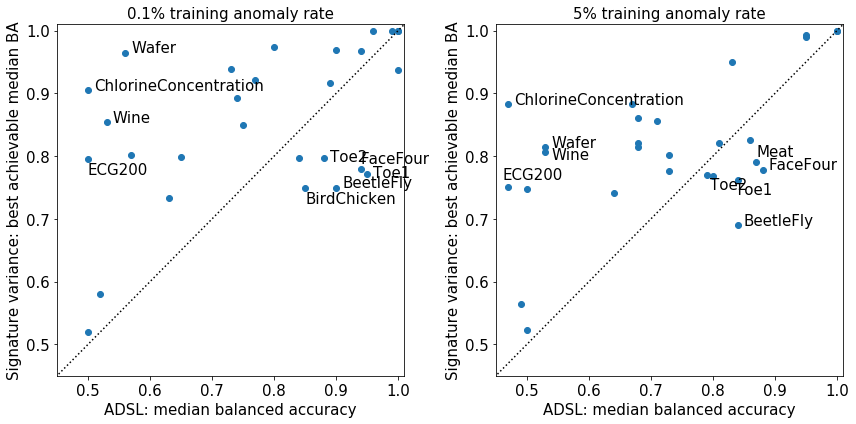

In [12]:
fontsize=15

fig, axs = plt.subplots(1,2, figsize=(12, 6))
ax=axs.flatten()[0]
roughpathsbest=[]
roughpathserror=[]
adslerror=[]
for dataset in comparisons.Dataset:
    balanced_accuracies = []
    for tnfn in tnfn1[dataset]:
        tn,fn=tnfn
        false_pos = np.flip(max(tn)-tn)
        true_pos = np.flip(max(fn)-fn)

        true_neg = max(false_pos)-false_pos
        false_neg = max(true_pos)-true_pos

        sens = true_pos/(true_pos+false_neg)
        spec = true_neg/(true_neg+false_pos)

        balanced_accuracies.append((sens+spec)/2)
    roughpathsbest.append(max(np.median(balanced_accuracies,axis=0)))
    bestthreshold=(np.argmax(np.median(balanced_accuracies,axis=0)))
    roughpathserror.append(np.std(balanced_accuracies,axis=0,ddof=1)[bestthreshold])
adslbest=np.maximum(comparisons.ADSL,comparisons.ADSLbest)
adslerror = comparisons['ADSL sd'] * (comparisons.ADSL>comparisons.ADSLbest) + comparisons['ADSLbest sd'] * (comparisons.ADSL<=comparisons.ADSLbest)
comparison_table1 = (pd.DataFrame(np.column_stack([comparisons.Dataset,roughpathsbest,roughpathserror,adslbest,adslerror])))

ax.scatter(adslbest,roughpathsbest)
ax.set_xlim(0.45,1.01)
ax.set_ylim(0.45,1.01)
import matplotlib.lines as mlines

line = mlines.Line2D([0, 1.01], [0, 1.01], color='black',ls=":")
ax.add_line(line)
ax.set_xlabel("ADSL: median balanced accuracy", fontsize=fontsize)
ax.set_ylabel("Signature variance: best achievable median BA", fontsize=fontsize)
ax.set_title("0.1% training anomaly rate", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
for i in range(len(adslbest)):
    if comparisons.Dataset[i] in ["Wafer","ChlorineConcentration","BeetleFly","Wine"]:
        ax.text(adslbest[i]+0.01,roughpathsbest[i],comparisons.Dataset[i], fontsize=fontsize)
    if comparisons.Dataset[i] in ["FaceFour"]:
        ax.text(adslbest[i],roughpathsbest[i]+0.01,comparisons.Dataset[i], fontsize=fontsize)
    if comparisons.Dataset[i] in ["ECG200","BirdChicken"]:
        ax.text(adslbest[i],roughpathsbest[i]-0.025,comparisons.Dataset[i], fontsize=fontsize)
    if comparisons.Dataset[i] in ["ToeSegmentation1","ToeSegmentation2"]:
        ax.text(adslbest[i]+0.01,roughpathsbest[i]-0.005,comparisons.Dataset[i][:3]+comparisons.Dataset[i][-1], fontsize=fontsize)
    
    #if comparisons.Dataset[i] in ["Wafer","ChlorineConcentration","BeetleFly","FaceFour"]:
    #    ax.text(adslbest[i]+0.01,roughpathsbest[i],comparisons.Dataset[i])
    
ax=axs.flatten()[1]

roughpathsbest=[]
roughpathserror=[]
for dataset in comparisons.Dataset:
    balanced_accuracies = []
    for tnfn in tnfn5[dataset]:
        tn,fn=tnfn
        false_pos = np.flip(max(tn)-tn)
        true_pos = np.flip(max(fn)-fn)

        true_neg = max(false_pos)-false_pos
        false_neg = max(true_pos)-true_pos

        sens = true_pos/(true_pos+false_neg)
        spec = true_neg/(true_neg+false_pos)

        balanced_accuracies.append((sens+spec)/2)
    roughpathsbest.append(max(np.median(balanced_accuracies,axis=0)))
    bestthreshold=(np.argmax(np.median(balanced_accuracies,axis=0)))
    roughpathserror.append(np.std(balanced_accuracies,axis=0,ddof=1)[bestthreshold])
#adslbest=np.maximum(comparisons.ADSL,comparisons.ADSLbest)
adslbest=comparisons["5% ADSL"]
adslerror = comparisons['5% ADSL sd']
comparison_table5 = (pd.DataFrame(np.column_stack([comparisons.Dataset,roughpathsbest,roughpathserror,adslbest,adslerror])))

for i in range(comparison_table1.shape[0]):
    print("%s & %1.2f (%1.2f) & %1.2f (%1.2f) & %1.2f (%1.2f) & %1.2f (%1.2f)\\\\" %(comparison_table1.iloc[i,0],
                                                     comparison_table1.iloc[i,1],comparison_table1.iloc[i,2],
                                                     comparison_table1.iloc[i,3],comparison_table1.iloc[i,4],
                                                     comparison_table5.iloc[i,1],comparison_table5.iloc[i,2],
                                                     comparison_table5.iloc[i,3],comparison_table5.iloc[i,4]))

#fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(adslbest,roughpathsbest)
ax.set_xlim(0.45,1.01)
ax.set_ylim(0.45,1.01)
import matplotlib.lines as mlines

line = mlines.Line2D([0, 1.01], [0, 1.01], color='black',ls=":")
ax.add_line(line)
ax.set_xlabel("ADSL: median balanced accuracy", fontsize=fontsize)
ax.set_ylabel("Signature variance: best achievable median BA", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.set_title("5% training anomaly rate", fontsize=fontsize)
for i in range(len(adslbest)):
    if comparisons.Dataset[i] in ["Wafer","ChlorineConcentration","BeetleFly","FaceFour"]:
        ax.text(adslbest[i]+0.01,roughpathsbest[i],comparisons.Dataset[i], fontsize=fontsize)
    if comparisons.Dataset[i] in ["Wine"]:
        ax.text(adslbest[i]+0.01,roughpathsbest[i]-0.01,comparisons.Dataset[i], fontsize=fontsize)
    if comparisons.Dataset[i] in ["ECG200"]:
        ax.text(adslbest[i]-0.01,roughpathsbest[i]+0.012,comparisons.Dataset[i], fontsize=fontsize)
    if comparisons.Dataset[i] in ["Meat"]:
        ax.text(adslbest[i],roughpathsbest[i]+0.01,comparisons.Dataset[i], fontsize=fontsize)
    if comparisons.Dataset[i] in ["ToeSegmentation1","ToeSegmentation2"]:
        ax.text(adslbest[i]-0.005,roughpathsbest[i]-0.022,comparisons.Dataset[i][:3]+comparisons.Dataset[i][-1], fontsize=fontsize)
fig.tight_layout()
fig.savefig("benchmark.pdf")
plt.show()

In [13]:
print('Execution time (s): {:.1f}'.format(time.time() - t0))

Execution time (s): 6253.8
